In [1]:
# import necessary libraries

# import built-in libraries
import os
import pandas as pd
import numpy as np
from glob import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns

# import functions from tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.svm import TimeSeriesSVC
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

# import functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# a function that aggregates all csv files
def aggregate_data(csv_dir, label):
    
    # get the list of all csv files
    csv_lst = glob(os.path.join(csv_dir, '*.csv'))
    
    # compile a regular expression to extract
    # the digits part of the file name
    r = re.compile('\D*(\d*).csv')
    
    # create a lambda expression with this regular expression
    extract_num = lambda x:int(r.search(x).group(1))
    
    # sort the file name in ascending order
    csv_lst.sort(key=extract_num)
                               
    # create an empty dataframe to hold the results
    df = pd.DataFrame()
    
    # process each csv file in turn
    for csv in csv_lst:
        
        # read in the data from this csv file
        df_tmp = pd.read_csv(csv)
        
        # strip the white spaces before and after the column names
        df_tmp.columns = df_tmp.columns.str.strip()
        
        # add a column to denote the video id
        df_tmp['vid'] = extract_num(csv)
        
        # add another column to denote the label
        df_tmp['label'] = label
        
        # append this dataframe to the aggregated dataframe
        df = df.append(df_tmp, ignore_index=True)
        
        # reset the index without keeping the old one
        df.reset_index(drop=True, inplace=True)
    
    # return the resulting dataframe
    return df

In [3]:
# a function that sanitizes data
def sanitize_data(df):
    
    # copy the dataset to tmp
    df_tmp = df.copy()
    
    # create a filter that filters out unsuccessful entries
    filt1 = df_tmp['success'] != 1
    
    # remove unsuccessful entries
    df_tmp.drop(index=df.loc[filt1].index, inplace=True)
    
    # create a filter that filters out low-confidence entries
    filt2 = df_tmp['confidence'] < 0.8
    
    # remove low-confidence entries
    df_tmp.drop(index=df_tmp.loc[filt2].index, inplace=True)
    
    # reset the index without keeping the old one
    df_tmp.reset_index(drop=True, inplace=True)
    
    # return the resulting dataframe
    return df_tmp

In [4]:
# set the root folder of the dataset
root = 'dataset'

# set the folder that contains the dataset for happy smiles
dir_happy = os.path.join(root,'happy_frames_openface')

# set the folder that contains the dataset for nervous smiles
dir_nervous = os.path.join(root,'nervous_frames_openface')

# aggregate the data for happy smiles
# the label for happy smiles is 1
df_happy = aggregate_data(dir_happy, 1)

# aggregate the data for nervous smiles
# the label for nervous smiles is 0
df_nervous = aggregate_data(dir_nervous, 0)

In [5]:
# data sanitizations

# the data for the happy smiles
df_happy = sanitize_data(df_happy)

# the data for the nervous smiles
df_nervous = sanitize_data(df_nervous)

# save to files
df_happy.to_csv('happy_smiles.csv')
df_nervous.to_csv('nervous_smiles.csv')

In [6]:
# a function that groups frames 
# belonging to each video
def group_featrues(df_features):
    
    # create an empty list to hold the results
    lst = []
    
    # process each entry by video id
    for vid in df_features['vid'].unique():
        
        # create a filter that leave frames
        # belonging to this vid alone
        filt = df_features['vid'] == vid
        
        # extract the frames belonging to this vid
        # convert to ndarray and add to the list
        lst.append(df_features[filt].drop(['vid'],axis=1).to_numpy())
    
    # return the results as a ndarray
    return np.array(lst)

In [7]:
# feature extraction

# selected features for classification
features = ['AU06_r','AU12_r', 'AU26_r','vid']

# extract features for happy smiles
df_happy_features = df_happy.loc[:,features]

# extract features for nervous smiles
df_nervous_features = df_nervous.loc[:,features]

# group features to a ndarray
np_happy_features = group_featrues(df_happy_features)
np_nervous_features = group_featrues(df_nervous_features)

# create a combined features
X = np.concatenate([np_happy_features,np_nervous_features])

# create a combined labels
y = np.concatenate([np.ones(np_happy_features.shape[0]), np.zeros(np_nervous_features.shape[0])])

In [8]:
# split the dataset into the training set and test set
X_train,X_test,y_train,y_test = train_test_split(X, y, shuffle=True, random_state=16, test_size = 0.2)

# convert these features to time series

# features from the training set 
X_train = to_time_series_dataset(X_train)

# features from the test set
X_test = to_time_series_dataset(X_test)

# feature scaling

# features from the training set 
#X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# features from the test set
#X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

In [9]:
# model selection

# create a kNN model with the metric of DTW 
svc = TimeSeriesSVC()

# possible k values
pgrid = {'kernel': ['gak','rbf'], 'C':list(range(1,10))}

# 5-fold cross-validation for training
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# create a searcher for the optimal value of k
grid_search = GridSearchCV(estimator=svc, n_jobs=6, param_grid=pgrid, cv=cv)

# SVM parameter tuning with the training set
grid_search.fit(X_train, y_train)

# get the optimal kernel from the grid search
k = grid_search.best_params_['kernel']

# get the optimal kernel
print(f'The optimal kernel for the kernel SVM is {k}')

# get the optimal C, penalty parameter C of the error term
# from the grid search
c = grid_search.best_params_['C']

# get the optimal kernel
print(f'The optimal C for the kernel SVM is {c}')

The optimal kernel for the kernel SVM is gak
The optimal C for the kernel SVM is 4


In [10]:
# create a optimal SVM model
svc_opt = TimeSeriesSVC(kernel=k, C=c, n_jobs=6)

# fit the SVM model to the training set
svc_opt.fit(X_train, y_train)

# predict the labels
y_train_predict = svc_opt.predict(X_train)
y_test_predict = svc_opt.predict(X_test)

The average accuracy of training is 68.64%
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        91
         1.0       1.00      1.00      1.00       180

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271

The confusion matrix for training:
[[ 91   0]
 [  0 180]]


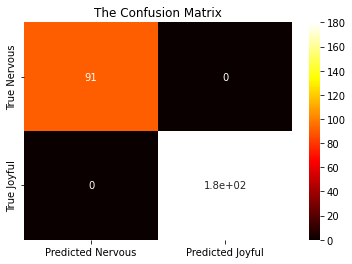

In [11]:
# get the training accuracy
# use 5-fold cross-validation
cvs_trn = cross_val_score(svc_opt, X_train, y_train, cv=5, scoring="accuracy")

# report the mean accuracy of training
print(f'The average accuracy of training is {np.mean(cvs_trn)*100:.2f}%')

# print classification report
print(classification_report(y_train, y_train_predict))

# compute the confusion matrix
cm_train = confusion_matrix(y_train, y_train_predict)

# display the confusion matrix
print('The confusion matrix for training:')
print(cm_train)

# plot the confusion matrix
# as a seaborn heatmap

# plot the heat map
heat_map = sns.heatmap(cm_train, annot=True, cmap='hot')

# set the tick labels
heat_map.set_xticklabels(['Predicted Nervous', 'Predicted Joyful'],
                         fontdict={'horizontalalignment': 'center'})

heat_map.set_yticklabels(['True Nervous', 'True Joyful'],
                         fontdict={'verticalalignment': 'center'})

# set the title
heat_map.set_title('The Confusion Matrix')

# show the plot
plt.show()

The average accuracy of testing is 66.26%
              precision    recall  f1-score   support

         0.0       1.00      0.22      0.36        23
         1.0       0.71      1.00      0.83        45

    accuracy                           0.74        68
   macro avg       0.86      0.61      0.60        68
weighted avg       0.81      0.74      0.67        68

The confusion matrix for testing:
[[ 5 18]
 [ 0 45]]


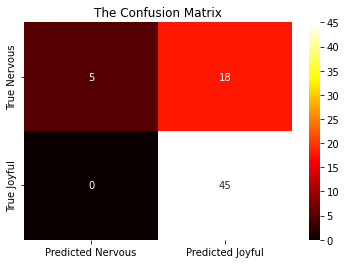

In [12]:
# get the testing accuracy
# use 5-fold cross-validation
cvs_test = cross_val_score(svc_opt, X_test, y_test, cv=5, scoring="accuracy")

# report the mean accuracy of training
print(f'The average accuracy of testing is {np.mean(cvs_test)*100:.2f}%')

# print classification report
print(classification_report(y_test, y_test_predict))

# compute the confusion matrix
cm_test = confusion_matrix(y_test, y_test_predict)

# display the confusion matrix
print('The confusion matrix for testing:')
print(cm_test)

# plot the confusion matrix
# as a seaborn heatmap

# plot the heat map
heat_map = sns.heatmap(cm_test, annot=True, cmap='hot')

# set the tick labels
heat_map.set_xticklabels(['Predicted Nervous', 'Predicted Joyful'],
                         fontdict={'horizontalalignment': 'center'})

heat_map.set_yticklabels(['True Nervous', 'True Joyful'],
                         fontdict={'verticalalignment': 'center'})

# set the title
heat_map.set_title('The Confusion Matrix')

# show the plot
plt.show()

In [13]:
# model selection

# create a kNN model with the metric of DTW 
knn = KNeighborsTimeSeriesClassifier(metric="dtw")

# possible k values
pgrid = {"n_neighbors": list(range(1, 3))}

# 5-fold cross-validation for training
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# create a searcher for the optimal value of k
grid_search = GridSearchCV(estimator=knn, n_jobs=6, param_grid=pgrid, cv=cv)

# kNN model tuning with the training set
grid_search.fit(X_train, y_train)

# get the best parameter from the grid search
k_opt = grid_search.best_params_['n_neighbors']

# get the optimal value of k
print(f'The optimal value of k is {k_opt} for time series kNN~')

The optimal value of k is 1 for time series kNN~


In [14]:
# create a kNN model with the optimal value of k
knn_opt = KNeighborsTimeSeriesClassifier(n_neighbors=k_opt, metric="dtw", n_jobs=6)

# fit the kNN model to the training set
knn_opt.fit(X_train, y_train)

# predict the labels
y_train_predict = knn_opt.predict(X_train)
y_test_predict = knn_opt.predict(X_test)

The average accuracy of training is 66.04%
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        91
         1.0       1.00      1.00      1.00       180

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271

The confusion matrix for training:
[[ 91   0]
 [  0 180]]


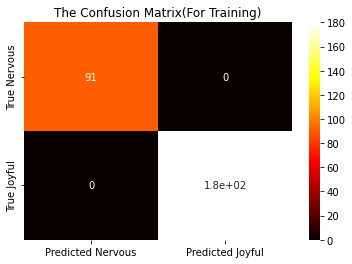

In [15]:
# get the testing accuracy
# use 5-fold cross-validation
cvs_train = cross_val_score(knn_opt, X_train, y_train, cv=5, scoring="accuracy")

# report the mean accuracy of training
print(f'The average accuracy of training is {np.mean(cvs_train)*100:.2f}%')

# print classification report
print(classification_report(y_train, y_train_predict))

# compute the confusion matrix
cm_train = confusion_matrix(y_train, y_train_predict)

# display the confusion matrix
print('The confusion matrix for training:')
print(cm_train)

# plot the confusion matrix
# as a seaborn heatmap

# plot the heat map
heat_map = sns.heatmap(cm_train, annot=True, cmap='hot')

# set the tick labels
heat_map.set_xticklabels(['Predicted Nervous', 'Predicted Joyful'],
                         fontdict={'horizontalalignment': 'center'})

heat_map.set_yticklabels(['True Nervous', 'True Joyful'],
                         fontdict={'verticalalignment': 'center'})

# set the title
heat_map.set_title('The Confusion Matrix(For Training)')

# show the plot
plt.show()

The average accuracy of testing is 69.34%
              precision    recall  f1-score   support

         0.0       0.42      0.35      0.38        23
         1.0       0.69      0.76      0.72        45

    accuracy                           0.62        68
   macro avg       0.56      0.55      0.55        68
weighted avg       0.60      0.62      0.61        68

The confusion matrix for testing:
[[ 8 15]
 [11 34]]


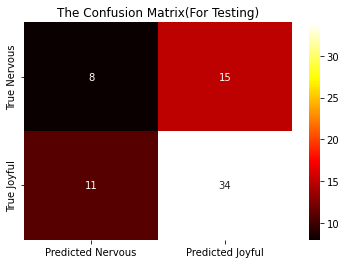

In [16]:
# get the testing accuracy
# use 5-fold cross-validation
cvs_test = cross_val_score(knn_opt, X_test, y_test, cv=5, scoring="accuracy")

# report the mean accuracy of training
print(f'The average accuracy of testing is {np.mean(cvs_test)*100:.2f}%')

# print classification report
print(classification_report(y_test, y_test_predict))

# compute the confusion matrix
cm_test = confusion_matrix(y_test, y_test_predict)

# display the confusion matrix
print('The confusion matrix for testing:')
print(cm_test)

# plot the confusion matrix
# as a seaborn heatmap

# plot the heat map
heat_map = sns.heatmap(cm_test, annot=True, cmap='hot')

# set the tick labels
heat_map.set_xticklabels(['Predicted Nervous', 'Predicted Joyful'],
                         fontdict={'horizontalalignment': 'center'})

heat_map.set_yticklabels(['True Nervous', 'True Joyful'],
                         fontdict={'verticalalignment': 'center'})

# set the title
heat_map.set_title('The Confusion Matrix(For Testing)')

# show the plot
plt.show()

In [17]:
svc_opt.gamma_

10.466199999044546

In [18]:
svc_opt.gamma

'auto'

In [19]:
svc_opt.gamma_

10.466199999044546